In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import model_selection, ensemble, metrics, linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
import os
base_dir = '../data'
print(os.listdir(base_dir))


# Any results you write to the current directory are saved as output.https://www.kaggle.com/wanermiranda/linear-regression-ml-tp1?scriptVersionId=5240484

['test.pkl', 'diamonds.csv', 'train.pkl']


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df_diamonds = pd.read_csv('%s/diamonds.csv'%(base_dir), index_col='Unnamed: 0')
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Numeric Features 
* Carat: weight of the diamond
* depth: depth %  The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
* table: table % The width of the diamond's table expressed as a percentage of its average diameter
* price: the price of the diamond
* xlength: mm
* ywidth: mm
* zdepth: mm

In [3]:
df_diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## cut 
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

In [4]:
cuts_ordered = ['Fair',
                'Good',
                'Very Good',
                'Premium',
                'Ideal']
df_diamonds['cut'] = df_diamonds['cut'].astype(CategoricalDtype(cuts_ordered, ordered=True))
print(df_diamonds['cut'].unique())
df_diamonds['cut'].describe()

[Ideal, Premium, Good, Very Good, Fair]
Categories (5, object): [Fair < Good < Very Good < Premium < Ideal]


count     53940
unique        5
top       Ideal
freq      21551
Name: cut, dtype: object

## color
mColor of the diamond, with D being the best and J the worst

In [5]:
colors_ordered = [  'J',
                    'I',
                    'H',
                    'G',
                    'F',
                    'E',
                    'D']
df_diamonds['color'] = df_diamonds['color'].astype(CategoricalDtype(colors_ordered, ordered=True))
print(df_diamonds['color'].unique())
df_diamonds['color'].describe()

[E, I, J, H, F, G, D]
Categories (7, object): [J < I < H < G < F < E < D]


count     53940
unique        7
top           G
freq      11292
Name: color, dtype: object

## clarity
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

In [6]:
clarity_codes = ['I3',
'I2',
'I1',
'SI2',
'SI1',
'VS2',
'VS1',
'VVS2',
'VVS1',
'IF',
'FL']
df_diamonds['clarity'] = df_diamonds['clarity'].astype(CategoricalDtype(clarity_codes, ordered=True))
print(df_diamonds['clarity'].unique())
df_diamonds['clarity'].describe()

[SI2, SI1, VS1, VS2, VVS2, VVS1, I1, IF]
Categories (8, object): [I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF]


count     53940
unique        8
top         SI1
freq      13065
Name: clarity, dtype: object

## Cleaning the Data
There are some zero dimensions for the diamonds, since that must be noise or mistype, we are cleaning it.


In [7]:
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.x <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.y <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.z <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.carat <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.depth <= 0].index)
df_diamonds = df_diamonds.drop(df_diamonds.loc[df_diamonds.table <= 0].index)

## Handcraft features
Since the measures for the diamond follow a 3d shape, we are considering here some handcraft features. 
Volume for the diamond = reflecting its size and weight. 
Ratio between the X, Y and Z.


In [8]:
df_diamonds['volume'] = df_diamonds['x'] * df_diamonds['y'] * df_diamonds['z']
df_diamonds['ratio_xy'] = df_diamonds['x'] / df_diamonds['y']
# df_diamonds['ratio_xz'] = df_diamonds['x'] / df_diamonds['z']
df_diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,ratio_xy
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030,0.992462
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,1.013021
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.995086
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580,0.992908
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250,0.997701
6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,38.693952,0.994949
7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,38.830870,0.992462
8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,42.321081,0.990268
9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,36.425214,1.023810
10,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,38.718000,0.987654


In [9]:
train, test_reserved = model_selection.train_test_split(df_diamonds, test_size=0.2, random_state=42)
test_reserved.to_csv('test.csv')
train.to_csv('train.csv')

df_diamonds = train

# Distribution Overview
The prices seems to follow a power law curve, as show bellow in the graph. 

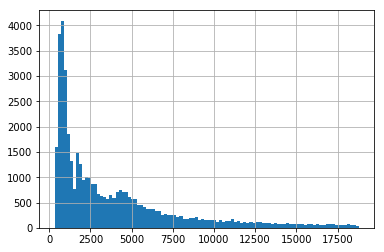

In [10]:
df_diamonds['price'].hist(bins=100)

In [11]:
df_diamonds['price'].describe()

count    43136.000000
mean      3926.531459
std       3983.079043
min        326.000000
25%        950.750000
50%       2398.000000
75%       5330.000000
max      18806.000000
Name: price, dtype: float64

## SGD Regression For Fun


In [12]:
cat_columns = df_diamonds.select_dtypes(['category']).columns.values
df_diamonds[cat_columns] = df_diamonds[cat_columns].apply(lambda x: x.cat.codes)



## Normalizing the Data
Using the robust scaller **to not only use the mean normalization**, but also to be less vulnerable to outliers.

In [13]:
X  = df_diamonds.copy()
y = X.pop('price')


## Regression
Since there is no negative values in the prices we are using here the log(price) to maintain this domain during the regression train. 
We are also using a 5 cross fold validation to do the grid search. 

A validation set was extracted from the data as a simulation for the test set.


In [14]:
from sklearn.model_selection import *

X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.1, random_state=42)
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [15]:

    
def sklLinearRegressionModel(X_train,y_train,best_hyperparams):
	regression = linear_model.SGDRegressor(**best_hyperparams, penalty=None, verbose=True) 
	regression.fit(X_train, np.log(y_train))
	return regression


def crossValidationKFold(X_train,y_train):
	hyperparams = {
    	'learning_rate':['invscaling', 'optimal'],
    	'eta0': [0.1, 0.05, 0.01], 
    	'max_iter':[20000, 10000]
	}

	scoring = {
    	'NEG_MSE': 'neg_mean_squared_error',
    	'NEG_MAE': 'neg_mean_absolute_error',
    	'VARIANCE': 'r2'
	}

	regr = GridSearchCV(linear_model.SGDRegressor(), hyperparams, cv=5, scoring=scoring, refit='VARIANCE', n_jobs=-1, verbose=True)

	regr.fit(X_train, np.log(y_train))

	return regr.best_params_


best_hyperparams = {'learning_rate': 'invscaling', 'max_iter': 2000, 'eta0': 0.01}
regr = sklLinearRegressionModel(X_train,y_train,best_hyperparams)

-- Epoch 1
Norm: 1.06, NNZs: 11, Bias: 7.672962, T: 38822, Avg. loss: 0.173894
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.30, NNZs: 11, Bias: 7.735181, T: 77644, Avg. loss: 0.017726
Total training time: 0.03 seconds.
-- Epoch 3
Norm: 1.45, NNZs: 11, Bias: 7.766603, T: 116466, Avg. loss: 0.013152
Total training time: 0.04 seconds.
-- Epoch 4
Norm: 1.55, NNZs: 11, Bias: 7.789205, T: 155288, Avg. loss: 0.011566
Total training time: 0.05 seconds.
-- Epoch 5
Norm: 1.60, NNZs: 11, Bias: 7.797126, T: 194110, Avg. loss: 0.011010
Total training time: 0.06 seconds.
-- Epoch 6
Norm: 1.64, NNZs: 11, Bias: 7.805718, T: 232932, Avg. loss: 0.010700
Total training time: 0.08 seconds.
-- Epoch 7
Norm: 1.67, NNZs: 11, Bias: 7.809644, T: 271754, Avg. loss: 0.010594
Total training time: 0.09 seconds.
-- Epoch 8
Norm: 1.69, NNZs: 11, Bias: 7.814387, T: 310576, Avg. loss: 0.010525
Total training time: 0.10 seconds.
-- Epoch 9
Norm: 1.70, NNZs: 11, Bias: 7.812832, T: 349398, Avg. loss: 0.010486
To

Norm: 1.80, NNZs: 11, Bias: 7.816051, T: 3377514, Avg. loss: 0.010290
Total training time: 1.04 seconds.
-- Epoch 88
Norm: 1.80, NNZs: 11, Bias: 7.816860, T: 3416336, Avg. loss: 0.010292
Total training time: 1.06 seconds.
-- Epoch 89
Norm: 1.80, NNZs: 11, Bias: 7.819155, T: 3455158, Avg. loss: 0.010289
Total training time: 1.07 seconds.
-- Epoch 90
Norm: 1.80, NNZs: 11, Bias: 7.817197, T: 3493980, Avg. loss: 0.010284
Total training time: 1.08 seconds.
-- Epoch 91
Norm: 1.80, NNZs: 11, Bias: 7.818300, T: 3532802, Avg. loss: 0.010288
Total training time: 1.09 seconds.
-- Epoch 92
Norm: 1.80, NNZs: 11, Bias: 7.817618, T: 3571624, Avg. loss: 0.010283
Total training time: 1.11 seconds.
-- Epoch 93
Norm: 1.80, NNZs: 11, Bias: 7.818571, T: 3610446, Avg. loss: 0.010287
Total training time: 1.12 seconds.
-- Epoch 94
Norm: 1.80, NNZs: 11, Bias: 7.817945, T: 3649268, Avg. loss: 0.010281
Total training time: 1.13 seconds.
-- Epoch 95
Norm: 1.80, NNZs: 11, Bias: 7.819012, T: 3688090, Avg. loss: 0.0

Norm: 1.86, NNZs: 11, Bias: 7.817225, T: 6289164, Avg. loss: 0.010222
Total training time: 1.87 seconds.
-- Epoch 163
Norm: 1.86, NNZs: 11, Bias: 7.816163, T: 6327986, Avg. loss: 0.010219
Total training time: 1.88 seconds.
-- Epoch 164
Norm: 1.86, NNZs: 11, Bias: 7.816844, T: 6366808, Avg. loss: 0.010221
Total training time: 1.90 seconds.
-- Epoch 165
Norm: 1.86, NNZs: 11, Bias: 7.815717, T: 6405630, Avg. loss: 0.010219
Total training time: 1.91 seconds.
-- Epoch 166
Norm: 1.86, NNZs: 11, Bias: 7.817833, T: 6444452, Avg. loss: 0.010219
Total training time: 1.92 seconds.
-- Epoch 167
Norm: 1.86, NNZs: 11, Bias: 7.815146, T: 6483274, Avg. loss: 0.010215
Total training time: 1.93 seconds.
-- Epoch 168
Norm: 1.86, NNZs: 11, Bias: 7.816065, T: 6522096, Avg. loss: 0.010217
Total training time: 1.94 seconds.
-- Epoch 169
Norm: 1.87, NNZs: 11, Bias: 7.815561, T: 6560918, Avg. loss: 0.010214
Total training time: 1.94 seconds.
-- Epoch 170
Norm: 1.87, NNZs: 11, Bias: 7.818485, T: 6599740, Avg. l

Norm: 1.92, NNZs: 11, Bias: 7.818322, T: 9239636, Avg. loss: 0.010177
Total training time: 2.70 seconds.
-- Epoch 239
Norm: 1.92, NNZs: 11, Bias: 7.816394, T: 9278458, Avg. loss: 0.010173
Total training time: 2.71 seconds.
-- Epoch 240
Norm: 1.93, NNZs: 11, Bias: 7.814315, T: 9317280, Avg. loss: 0.010175
Total training time: 2.72 seconds.
-- Epoch 241
Norm: 1.93, NNZs: 11, Bias: 7.817287, T: 9356102, Avg. loss: 0.010169
Total training time: 2.73 seconds.
-- Epoch 242
Norm: 1.93, NNZs: 11, Bias: 7.816467, T: 9394924, Avg. loss: 0.010172
Total training time: 2.74 seconds.
-- Epoch 243
Norm: 1.93, NNZs: 11, Bias: 7.816934, T: 9433746, Avg. loss: 0.010172
Total training time: 2.76 seconds.
-- Epoch 244
Norm: 1.93, NNZs: 11, Bias: 7.815635, T: 9472568, Avg. loss: 0.010166
Total training time: 2.77 seconds.
-- Epoch 245
Norm: 1.93, NNZs: 11, Bias: 7.816340, T: 9511390, Avg. loss: 0.010168
Total training time: 2.78 seconds.
-- Epoch 246
Norm: 1.93, NNZs: 11, Bias: 7.814231, T: 9550212, Avg. l

Norm: 1.99, NNZs: 11, Bias: 7.813124, T: 12655972, Avg. loss: 0.010137
Total training time: 3.74 seconds.
-- Epoch 327
Norm: 1.99, NNZs: 11, Bias: 7.814209, T: 12694794, Avg. loss: 0.010134
Total training time: 3.75 seconds.
-- Epoch 328
Norm: 1.99, NNZs: 11, Bias: 7.815925, T: 12733616, Avg. loss: 0.010135
Total training time: 3.76 seconds.
-- Epoch 329
Norm: 1.99, NNZs: 11, Bias: 7.813542, T: 12772438, Avg. loss: 0.010135
Total training time: 3.77 seconds.
-- Epoch 330
Norm: 1.99, NNZs: 11, Bias: 7.814522, T: 12811260, Avg. loss: 0.010131
Total training time: 3.78 seconds.
-- Epoch 331
Norm: 2.00, NNZs: 11, Bias: 7.814864, T: 12850082, Avg. loss: 0.010136
Total training time: 3.79 seconds.
-- Epoch 332
Norm: 2.00, NNZs: 11, Bias: 7.814449, T: 12888904, Avg. loss: 0.010133
Total training time: 3.81 seconds.
-- Epoch 333
Norm: 2.00, NNZs: 11, Bias: 7.814107, T: 12927726, Avg. loss: 0.010133
Total training time: 3.82 seconds.
-- Epoch 334
Norm: 2.00, NNZs: 11, Bias: 7.815608, T: 1296654

Norm: 2.04, NNZs: 11, Bias: 7.813712, T: 15412334, Avg. loss: 0.010114
Total training time: 4.55 seconds.
-- Epoch 398
Norm: 2.04, NNZs: 11, Bias: 7.813952, T: 15451156, Avg. loss: 0.010113
Total training time: 4.56 seconds.
-- Epoch 399
Norm: 2.04, NNZs: 11, Bias: 7.815957, T: 15489978, Avg. loss: 0.010112
Total training time: 4.57 seconds.
-- Epoch 400
Norm: 2.04, NNZs: 11, Bias: 7.814100, T: 15528800, Avg. loss: 0.010108
Total training time: 4.59 seconds.
-- Epoch 401
Norm: 2.04, NNZs: 11, Bias: 7.814773, T: 15567622, Avg. loss: 0.010110
Total training time: 4.60 seconds.
-- Epoch 402
Norm: 2.05, NNZs: 11, Bias: 7.814891, T: 15606444, Avg. loss: 0.010110
Total training time: 4.61 seconds.
-- Epoch 403
Norm: 2.04, NNZs: 11, Bias: 7.815290, T: 15645266, Avg. loss: 0.010111
Total training time: 4.62 seconds.
-- Epoch 404
Norm: 2.05, NNZs: 11, Bias: 7.814537, T: 15684088, Avg. loss: 0.010111
Total training time: 4.63 seconds.
-- Epoch 405
Norm: 2.05, NNZs: 11, Bias: 7.815189, T: 1572291

Norm: 2.09, NNZs: 11, Bias: 7.814327, T: 18168696, Avg. loss: 0.010092
Total training time: 5.38 seconds.
-- Epoch 469
Norm: 2.09, NNZs: 11, Bias: 7.814398, T: 18207518, Avg. loss: 0.010094
Total training time: 5.39 seconds.
-- Epoch 470
Norm: 2.09, NNZs: 11, Bias: 7.814875, T: 18246340, Avg. loss: 0.010091
Total training time: 5.41 seconds.
-- Epoch 471
Norm: 2.09, NNZs: 11, Bias: 7.813207, T: 18285162, Avg. loss: 0.010094
Total training time: 5.42 seconds.
-- Epoch 472
Norm: 2.09, NNZs: 11, Bias: 7.815236, T: 18323984, Avg. loss: 0.010092
Total training time: 5.43 seconds.
-- Epoch 473
Norm: 2.09, NNZs: 11, Bias: 7.814749, T: 18362806, Avg. loss: 0.010093
Total training time: 5.44 seconds.
-- Epoch 474
Norm: 2.09, NNZs: 11, Bias: 7.813273, T: 18401628, Avg. loss: 0.010091
Total training time: 5.45 seconds.
-- Epoch 475
Norm: 2.09, NNZs: 11, Bias: 7.813924, T: 18440450, Avg. loss: 0.010094
Total training time: 5.46 seconds.
-- Epoch 476
Norm: 2.09, NNZs: 11, Bias: 7.814064, T: 1847927

Norm: 2.13, NNZs: 11, Bias: 7.814126, T: 21041524, Avg. loss: 0.010077
Total training time: 6.20 seconds.
-- Epoch 543
Norm: 2.13, NNZs: 11, Bias: 7.815554, T: 21080346, Avg. loss: 0.010076
Total training time: 6.22 seconds.
-- Epoch 544
Norm: 2.13, NNZs: 11, Bias: 7.815034, T: 21119168, Avg. loss: 0.010077
Total training time: 6.23 seconds.
-- Epoch 545
Norm: 2.13, NNZs: 11, Bias: 7.815303, T: 21157990, Avg. loss: 0.010079
Total training time: 6.24 seconds.
-- Epoch 546
Norm: 2.13, NNZs: 11, Bias: 7.813402, T: 21196812, Avg. loss: 0.010075
Total training time: 6.25 seconds.
-- Epoch 547
Norm: 2.14, NNZs: 11, Bias: 7.813397, T: 21235634, Avg. loss: 0.010079
Total training time: 6.26 seconds.
-- Epoch 548
Norm: 2.14, NNZs: 11, Bias: 7.814541, T: 21274456, Avg. loss: 0.010076
Total training time: 6.27 seconds.
-- Epoch 549
Norm: 2.14, NNZs: 11, Bias: 7.815205, T: 21313278, Avg. loss: 0.010075
Total training time: 6.28 seconds.
-- Epoch 550
Norm: 2.14, NNZs: 11, Bias: 7.813014, T: 2135210

Norm: 2.17, NNZs: 11, Bias: 7.814071, T: 23836708, Avg. loss: 0.010061
Total training time: 7.04 seconds.
-- Epoch 615
Norm: 2.17, NNZs: 11, Bias: 7.812978, T: 23875530, Avg. loss: 0.010066
Total training time: 7.05 seconds.
-- Epoch 616
Norm: 2.18, NNZs: 11, Bias: 7.812337, T: 23914352, Avg. loss: 0.010064
Total training time: 7.06 seconds.
-- Epoch 617
Norm: 2.18, NNZs: 11, Bias: 7.812421, T: 23953174, Avg. loss: 0.010064
Total training time: 7.07 seconds.
-- Epoch 618
Norm: 2.18, NNZs: 11, Bias: 7.813272, T: 23991996, Avg. loss: 0.010063
Total training time: 7.08 seconds.
-- Epoch 619
Norm: 2.18, NNZs: 11, Bias: 7.812456, T: 24030818, Avg. loss: 0.010064
Total training time: 7.09 seconds.
-- Epoch 620
Norm: 2.18, NNZs: 11, Bias: 7.812805, T: 24069640, Avg. loss: 0.010063
Total training time: 7.10 seconds.
-- Epoch 621
Norm: 2.18, NNZs: 11, Bias: 7.811661, T: 24108462, Avg. loss: 0.010060
Total training time: 7.11 seconds.
-- Epoch 622
Norm: 2.18, NNZs: 11, Bias: 7.812967, T: 2414728

Norm: 2.21, NNZs: 11, Bias: 7.814404, T: 26554248, Avg. loss: 0.010051
Total training time: 7.87 seconds.
-- Epoch 685
Norm: 2.21, NNZs: 11, Bias: 7.812652, T: 26593070, Avg. loss: 0.010051
Total training time: 7.88 seconds.
-- Epoch 686
Norm: 2.21, NNZs: 11, Bias: 7.813717, T: 26631892, Avg. loss: 0.010053
Total training time: 7.89 seconds.
-- Epoch 687
Norm: 2.21, NNZs: 11, Bias: 7.812341, T: 26670714, Avg. loss: 0.010051
Total training time: 7.90 seconds.
-- Epoch 688
Norm: 2.21, NNZs: 11, Bias: 7.813847, T: 26709536, Avg. loss: 0.010053
Total training time: 7.92 seconds.
-- Epoch 689
Norm: 2.21, NNZs: 11, Bias: 7.812058, T: 26748358, Avg. loss: 0.010050
Total training time: 7.93 seconds.
-- Epoch 690
Norm: 2.21, NNZs: 11, Bias: 7.814090, T: 26787180, Avg. loss: 0.010050
Total training time: 7.94 seconds.
-- Epoch 691
Norm: 2.22, NNZs: 11, Bias: 7.814293, T: 26826002, Avg. loss: 0.010053
Total training time: 7.95 seconds.
-- Epoch 692
Norm: 2.22, NNZs: 11, Bias: 7.812945, T: 2686482

Norm: 2.25, NNZs: 11, Bias: 7.812565, T: 29310610, Avg. loss: 0.010040
Total training time: 8.71 seconds.
-- Epoch 756
Norm: 2.25, NNZs: 11, Bias: 7.814770, T: 29349432, Avg. loss: 0.010042
Total training time: 8.73 seconds.
-- Epoch 757
Norm: 2.25, NNZs: 11, Bias: 7.812420, T: 29388254, Avg. loss: 0.010042
Total training time: 8.74 seconds.
-- Epoch 758
Norm: 2.25, NNZs: 11, Bias: 7.812763, T: 29427076, Avg. loss: 0.010042
Total training time: 8.75 seconds.
-- Epoch 759
Norm: 2.25, NNZs: 11, Bias: 7.812405, T: 29465898, Avg. loss: 0.010040
Total training time: 8.76 seconds.
-- Epoch 760
Norm: 2.25, NNZs: 11, Bias: 7.812277, T: 29504720, Avg. loss: 0.010043
Total training time: 8.77 seconds.
-- Epoch 761
Norm: 2.25, NNZs: 11, Bias: 7.813720, T: 29543542, Avg. loss: 0.010039
Total training time: 8.78 seconds.
-- Epoch 762
Norm: 2.25, NNZs: 11, Bias: 7.812534, T: 29582364, Avg. loss: 0.010043
Total training time: 8.79 seconds.
-- Epoch 763
Norm: 2.25, NNZs: 11, Bias: 7.814047, T: 2962118

Norm: 2.28, NNZs: 11, Bias: 7.810372, T: 32299904, Avg. loss: 0.010033
Total training time: 9.54 seconds.
-- Epoch 833
Norm: 2.28, NNZs: 11, Bias: 7.811915, T: 32338726, Avg. loss: 0.010032
Total training time: 9.56 seconds.
-- Epoch 834
Norm: 2.28, NNZs: 11, Bias: 7.812590, T: 32377548, Avg. loss: 0.010032
Total training time: 9.57 seconds.
-- Epoch 835
Norm: 2.28, NNZs: 11, Bias: 7.813446, T: 32416370, Avg. loss: 0.010033
Total training time: 9.58 seconds.
-- Epoch 836
Norm: 2.29, NNZs: 11, Bias: 7.810392, T: 32455192, Avg. loss: 0.010031
Total training time: 9.59 seconds.
-- Epoch 837
Norm: 2.29, NNZs: 11, Bias: 7.810846, T: 32494014, Avg. loss: 0.010032
Total training time: 9.60 seconds.
-- Epoch 838
Norm: 2.29, NNZs: 11, Bias: 7.812792, T: 32532836, Avg. loss: 0.010032
Total training time: 9.61 seconds.
-- Epoch 839
Norm: 2.29, NNZs: 11, Bias: 7.812975, T: 32571658, Avg. loss: 0.010032
Total training time: 9.62 seconds.
-- Epoch 840
Norm: 2.29, NNZs: 11, Bias: 7.811960, T: 3261048

Norm: 2.32, NNZs: 11, Bias: 7.812129, T: 35366842, Avg. loss: 0.010025
Total training time: 10.37 seconds.
-- Epoch 912
Norm: 2.32, NNZs: 11, Bias: 7.810907, T: 35405664, Avg. loss: 0.010026
Total training time: 10.38 seconds.
-- Epoch 913
Norm: 2.32, NNZs: 11, Bias: 7.813196, T: 35444486, Avg. loss: 0.010024
Total training time: 10.40 seconds.
-- Epoch 914
Norm: 2.32, NNZs: 11, Bias: 7.811482, T: 35483308, Avg. loss: 0.010023
Total training time: 10.41 seconds.
-- Epoch 915
Norm: 2.32, NNZs: 11, Bias: 7.813647, T: 35522130, Avg. loss: 0.010026
Total training time: 10.42 seconds.
-- Epoch 916
Norm: 2.32, NNZs: 11, Bias: 7.812833, T: 35560952, Avg. loss: 0.010025
Total training time: 10.43 seconds.
-- Epoch 917
Norm: 2.32, NNZs: 11, Bias: 7.812663, T: 35599774, Avg. loss: 0.010024
Total training time: 10.44 seconds.
-- Epoch 918
Norm: 2.32, NNZs: 11, Bias: 7.813777, T: 35638596, Avg. loss: 0.010024
Total training time: 10.45 seconds.
-- Epoch 919
Norm: 2.32, NNZs: 11, Bias: 7.812483, T:

Norm: 2.35, NNZs: 11, Bias: 7.811365, T: 38550246, Avg. loss: 0.010018
Total training time: 11.20 seconds.
-- Epoch 994
Norm: 2.35, NNZs: 11, Bias: 7.812891, T: 38589068, Avg. loss: 0.010018
Total training time: 11.22 seconds.
-- Epoch 995
Norm: 2.35, NNZs: 11, Bias: 7.810866, T: 38627890, Avg. loss: 0.010019
Total training time: 11.23 seconds.
-- Epoch 996
Norm: 2.35, NNZs: 11, Bias: 7.811732, T: 38666712, Avg. loss: 0.010019
Total training time: 11.24 seconds.
-- Epoch 997
Norm: 2.35, NNZs: 11, Bias: 7.811436, T: 38705534, Avg. loss: 0.010019
Total training time: 11.25 seconds.
-- Epoch 998
Norm: 2.35, NNZs: 11, Bias: 7.812685, T: 38744356, Avg. loss: 0.010017
Total training time: 11.26 seconds.
-- Epoch 999
Norm: 2.36, NNZs: 11, Bias: 7.810776, T: 38783178, Avg. loss: 0.010019
Total training time: 11.27 seconds.
-- Epoch 1000
Norm: 2.36, NNZs: 11, Bias: 7.810605, T: 38822000, Avg. loss: 0.010016
Total training time: 11.28 seconds.
-- Epoch 1001
Norm: 2.36, NNZs: 11, Bias: 7.810118, 

-- Epoch 1076
Norm: 2.39, NNZs: 11, Bias: 7.811885, T: 41772472, Avg. loss: 0.010010
Total training time: 12.04 seconds.
-- Epoch 1077
Norm: 2.38, NNZs: 11, Bias: 7.810376, T: 41811294, Avg. loss: 0.010010
Total training time: 12.05 seconds.
-- Epoch 1078
Norm: 2.39, NNZs: 11, Bias: 7.812399, T: 41850116, Avg. loss: 0.010014
Total training time: 12.06 seconds.
-- Epoch 1079
Norm: 2.39, NNZs: 11, Bias: 7.812044, T: 41888938, Avg. loss: 0.010011
Total training time: 12.07 seconds.
-- Epoch 1080
Norm: 2.39, NNZs: 11, Bias: 7.812177, T: 41927760, Avg. loss: 0.010012
Total training time: 12.08 seconds.
-- Epoch 1081
Norm: 2.39, NNZs: 11, Bias: 7.811775, T: 41966582, Avg. loss: 0.010011
Total training time: 12.09 seconds.
-- Epoch 1082
Norm: 2.39, NNZs: 11, Bias: 7.810920, T: 42005404, Avg. loss: 0.010009
Total training time: 12.10 seconds.
-- Epoch 1083
Norm: 2.39, NNZs: 11, Bias: 7.811916, T: 42044226, Avg. loss: 0.010011
Total training time: 12.11 seconds.
-- Epoch 1084
Norm: 2.39, NNZs: 

Norm: 2.41, NNZs: 11, Bias: 7.812892, T: 44839410, Avg. loss: 0.010002
Total training time: 12.87 seconds.
-- Epoch 1156
Norm: 2.41, NNZs: 11, Bias: 7.813302, T: 44878232, Avg. loss: 0.010006
Total training time: 12.88 seconds.
-- Epoch 1157
Norm: 2.41, NNZs: 11, Bias: 7.811476, T: 44917054, Avg. loss: 0.010007
Total training time: 12.89 seconds.
-- Epoch 1158
Norm: 2.41, NNZs: 11, Bias: 7.810236, T: 44955876, Avg. loss: 0.010002
Total training time: 12.90 seconds.
-- Epoch 1159
Norm: 2.42, NNZs: 11, Bias: 7.812096, T: 44994698, Avg. loss: 0.010005
Total training time: 12.91 seconds.
-- Epoch 1160
Norm: 2.42, NNZs: 11, Bias: 7.812298, T: 45033520, Avg. loss: 0.010007
Total training time: 12.92 seconds.
-- Epoch 1161
Norm: 2.42, NNZs: 11, Bias: 7.811006, T: 45072342, Avg. loss: 0.010007
Total training time: 12.93 seconds.
-- Epoch 1162
Norm: 2.42, NNZs: 11, Bias: 7.812109, T: 45111164, Avg. loss: 0.010005
Total training time: 12.94 seconds.
-- Epoch 1163
Norm: 2.42, NNZs: 11, Bias: 7.81

Norm: 2.44, NNZs: 11, Bias: 7.811749, T: 48100458, Avg. loss: 0.009999
Total training time: 13.71 seconds.
-- Epoch 1240
Norm: 2.44, NNZs: 11, Bias: 7.810945, T: 48139280, Avg. loss: 0.010001
Total training time: 13.72 seconds.
-- Epoch 1241
Norm: 2.44, NNZs: 11, Bias: 7.810411, T: 48178102, Avg. loss: 0.009999
Total training time: 13.73 seconds.
-- Epoch 1242
Norm: 2.44, NNZs: 11, Bias: 7.810728, T: 48216924, Avg. loss: 0.010002
Total training time: 13.74 seconds.
-- Epoch 1243
Norm: 2.44, NNZs: 11, Bias: 7.811564, T: 48255746, Avg. loss: 0.010001
Total training time: 13.75 seconds.
-- Epoch 1244
Norm: 2.44, NNZs: 11, Bias: 7.812864, T: 48294568, Avg. loss: 0.010001
Total training time: 13.76 seconds.
-- Epoch 1245
Norm: 2.44, NNZs: 11, Bias: 7.811429, T: 48333390, Avg. loss: 0.009999
Total training time: 13.77 seconds.
-- Epoch 1246
Norm: 2.45, NNZs: 11, Bias: 7.812846, T: 48372212, Avg. loss: 0.009998
Total training time: 13.78 seconds.
-- Epoch 1247
Norm: 2.44, NNZs: 11, Bias: 7.81

Norm: 2.47, NNZs: 11, Bias: 7.810148, T: 51283862, Avg. loss: 0.009997
Total training time: 14.54 seconds.
-- Epoch 1322
Norm: 2.47, NNZs: 11, Bias: 7.810521, T: 51322684, Avg. loss: 0.009999
Total training time: 14.55 seconds.
-- Epoch 1323
Norm: 2.47, NNZs: 11, Bias: 7.811716, T: 51361506, Avg. loss: 0.009994
Total training time: 14.56 seconds.
-- Epoch 1324
Norm: 2.47, NNZs: 11, Bias: 7.811223, T: 51400328, Avg. loss: 0.009997
Total training time: 14.57 seconds.
-- Epoch 1325
Norm: 2.47, NNZs: 11, Bias: 7.811468, T: 51439150, Avg. loss: 0.009997
Total training time: 14.58 seconds.
-- Epoch 1326
Norm: 2.47, NNZs: 11, Bias: 7.812204, T: 51477972, Avg. loss: 0.009998
Total training time: 14.59 seconds.
-- Epoch 1327
Norm: 2.47, NNZs: 11, Bias: 7.812524, T: 51516794, Avg. loss: 0.009996
Total training time: 14.60 seconds.
-- Epoch 1328
Norm: 2.47, NNZs: 11, Bias: 7.812480, T: 51555616, Avg. loss: 0.009996
Total training time: 14.61 seconds.
-- Epoch 1329
Norm: 2.47, NNZs: 11, Bias: 7.81

Norm: 2.49, NNZs: 11, Bias: 7.811473, T: 54506088, Avg. loss: 0.009993
Total training time: 15.37 seconds.
-- Epoch 1405
Norm: 2.49, NNZs: 11, Bias: 7.810139, T: 54544910, Avg. loss: 0.009994
Total training time: 15.38 seconds.
-- Epoch 1406
Norm: 2.50, NNZs: 11, Bias: 7.809579, T: 54583732, Avg. loss: 0.009993
Total training time: 15.39 seconds.
-- Epoch 1407
Norm: 2.50, NNZs: 11, Bias: 7.810789, T: 54622554, Avg. loss: 0.009993
Total training time: 15.40 seconds.
-- Epoch 1408
Norm: 2.50, NNZs: 11, Bias: 7.811484, T: 54661376, Avg. loss: 0.009992
Total training time: 15.41 seconds.
-- Epoch 1409
Norm: 2.50, NNZs: 11, Bias: 7.808604, T: 54700198, Avg. loss: 0.009993
Total training time: 15.42 seconds.
-- Epoch 1410
Norm: 2.50, NNZs: 11, Bias: 7.810001, T: 54739020, Avg. loss: 0.009995
Total training time: 15.43 seconds.
-- Epoch 1411
Norm: 2.50, NNZs: 11, Bias: 7.809821, T: 54777842, Avg. loss: 0.009989
Total training time: 15.44 seconds.
-- Epoch 1412
Norm: 2.50, NNZs: 11, Bias: 7.81

Norm: 2.52, NNZs: 11, Bias: 7.811893, T: 57650670, Avg. loss: 0.009989
Total training time: 16.21 seconds.
-- Epoch 1486
Norm: 2.52, NNZs: 11, Bias: 7.811711, T: 57689492, Avg. loss: 0.009991
Total training time: 16.22 seconds.
-- Epoch 1487
Norm: 2.52, NNZs: 11, Bias: 7.810274, T: 57728314, Avg. loss: 0.009989
Total training time: 16.23 seconds.
-- Epoch 1488
Norm: 2.52, NNZs: 11, Bias: 7.810251, T: 57767136, Avg. loss: 0.009989
Total training time: 16.24 seconds.
-- Epoch 1489
Norm: 2.52, NNZs: 11, Bias: 7.810056, T: 57805958, Avg. loss: 0.009987
Total training time: 16.25 seconds.
-- Epoch 1490
Norm: 2.52, NNZs: 11, Bias: 7.811178, T: 57844780, Avg. loss: 0.009989
Total training time: 16.26 seconds.
-- Epoch 1491
Norm: 2.52, NNZs: 11, Bias: 7.810048, T: 57883602, Avg. loss: 0.009987
Total training time: 16.27 seconds.
-- Epoch 1492
Norm: 2.52, NNZs: 11, Bias: 7.810195, T: 57922424, Avg. loss: 0.009991
Total training time: 16.28 seconds.
-- Epoch 1493
Norm: 2.52, NNZs: 11, Bias: 7.81

Norm: 2.54, NNZs: 11, Bias: 7.809146, T: 60834074, Avg. loss: 0.009984
Total training time: 17.04 seconds.
-- Epoch 1568
Norm: 2.54, NNZs: 11, Bias: 7.811286, T: 60872896, Avg. loss: 0.009989
Total training time: 17.05 seconds.
-- Epoch 1569
Norm: 2.54, NNZs: 11, Bias: 7.811026, T: 60911718, Avg. loss: 0.009986
Total training time: 17.07 seconds.
-- Epoch 1570
Norm: 2.54, NNZs: 11, Bias: 7.811472, T: 60950540, Avg. loss: 0.009988
Total training time: 17.08 seconds.
-- Epoch 1571
Norm: 2.54, NNZs: 11, Bias: 7.809918, T: 60989362, Avg. loss: 0.009987
Total training time: 17.09 seconds.
-- Epoch 1572
Norm: 2.54, NNZs: 11, Bias: 7.810897, T: 61028184, Avg. loss: 0.009988
Total training time: 17.10 seconds.
-- Epoch 1573
Norm: 2.54, NNZs: 11, Bias: 7.812106, T: 61067006, Avg. loss: 0.009984
Total training time: 17.10 seconds.
-- Epoch 1574
Norm: 2.54, NNZs: 11, Bias: 7.810780, T: 61105828, Avg. loss: 0.009985
Total training time: 17.11 seconds.
-- Epoch 1575
Norm: 2.54, NNZs: 11, Bias: 7.80

Norm: 2.56, NNZs: 11, Bias: 7.810918, T: 64056300, Avg. loss: 0.009986
Total training time: 17.88 seconds.
-- Epoch 1651
Norm: 2.56, NNZs: 11, Bias: 7.810297, T: 64095122, Avg. loss: 0.009984
Total training time: 17.89 seconds.
-- Epoch 1652
Norm: 2.56, NNZs: 11, Bias: 7.810088, T: 64133944, Avg. loss: 0.009982
Total training time: 17.90 seconds.
-- Epoch 1653
Norm: 2.56, NNZs: 11, Bias: 7.810579, T: 64172766, Avg. loss: 0.009984
Total training time: 17.91 seconds.
-- Epoch 1654
Norm: 2.56, NNZs: 11, Bias: 7.810828, T: 64211588, Avg. loss: 0.009984
Total training time: 17.92 seconds.
-- Epoch 1655
Norm: 2.56, NNZs: 11, Bias: 7.810224, T: 64250410, Avg. loss: 0.009984
Total training time: 17.93 seconds.
-- Epoch 1656
Norm: 2.56, NNZs: 11, Bias: 7.810302, T: 64289232, Avg. loss: 0.009984
Total training time: 17.94 seconds.
-- Epoch 1657
Norm: 2.56, NNZs: 11, Bias: 7.810901, T: 64328054, Avg. loss: 0.009985
Total training time: 17.95 seconds.
-- Epoch 1658
Norm: 2.56, NNZs: 11, Bias: 7.81

Norm: 2.58, NNZs: 11, Bias: 7.810918, T: 67239704, Avg. loss: 0.009980
Total training time: 18.71 seconds.
-- Epoch 1733
Norm: 2.58, NNZs: 11, Bias: 7.809634, T: 67278526, Avg. loss: 0.009981
Total training time: 18.72 seconds.
-- Epoch 1734
Norm: 2.58, NNZs: 11, Bias: 7.809418, T: 67317348, Avg. loss: 0.009979
Total training time: 18.73 seconds.
-- Epoch 1735
Norm: 2.58, NNZs: 11, Bias: 7.810243, T: 67356170, Avg. loss: 0.009983
Total training time: 18.74 seconds.
-- Epoch 1736
Norm: 2.58, NNZs: 11, Bias: 7.810095, T: 67394992, Avg. loss: 0.009981
Total training time: 18.75 seconds.
-- Epoch 1737
Norm: 2.58, NNZs: 11, Bias: 7.811028, T: 67433814, Avg. loss: 0.009981
Total training time: 18.76 seconds.
-- Epoch 1738
Norm: 2.58, NNZs: 11, Bias: 7.810808, T: 67472636, Avg. loss: 0.009980
Total training time: 18.77 seconds.
-- Epoch 1739
Norm: 2.58, NNZs: 11, Bias: 7.808177, T: 67511458, Avg. loss: 0.009980
Total training time: 18.78 seconds.
-- Epoch 1740
Norm: 2.58, NNZs: 11, Bias: 7.81

Norm: 2.60, NNZs: 11, Bias: 7.809479, T: 70500752, Avg. loss: 0.009980
Total training time: 19.54 seconds.
-- Epoch 1817
Norm: 2.60, NNZs: 11, Bias: 7.810000, T: 70539574, Avg. loss: 0.009980
Total training time: 19.55 seconds.
-- Epoch 1818
Norm: 2.60, NNZs: 11, Bias: 7.809902, T: 70578396, Avg. loss: 0.009981
Total training time: 19.56 seconds.
-- Epoch 1819
Norm: 2.60, NNZs: 11, Bias: 7.809799, T: 70617218, Avg. loss: 0.009980
Total training time: 19.57 seconds.
-- Epoch 1820
Norm: 2.60, NNZs: 11, Bias: 7.810372, T: 70656040, Avg. loss: 0.009980
Total training time: 19.58 seconds.
-- Epoch 1821
Norm: 2.60, NNZs: 11, Bias: 7.809656, T: 70694862, Avg. loss: 0.009977
Total training time: 19.59 seconds.
-- Epoch 1822
Norm: 2.60, NNZs: 11, Bias: 7.809115, T: 70733684, Avg. loss: 0.009979
Total training time: 19.60 seconds.
-- Epoch 1823
Norm: 2.60, NNZs: 11, Bias: 7.809978, T: 70772506, Avg. loss: 0.009980
Total training time: 19.61 seconds.
-- Epoch 1824
Norm: 2.60, NNZs: 11, Bias: 7.81

Norm: 2.62, NNZs: 11, Bias: 7.809825, T: 73645334, Avg. loss: 0.009977
Total training time: 20.36 seconds.
-- Epoch 1898
Norm: 2.62, NNZs: 11, Bias: 7.809273, T: 73684156, Avg. loss: 0.009978
Total training time: 20.37 seconds.
-- Epoch 1899
Norm: 2.62, NNZs: 11, Bias: 7.810242, T: 73722978, Avg. loss: 0.009979
Total training time: 20.38 seconds.
-- Epoch 1900
Norm: 2.62, NNZs: 11, Bias: 7.810169, T: 73761800, Avg. loss: 0.009979
Total training time: 20.40 seconds.
-- Epoch 1901
Norm: 2.62, NNZs: 11, Bias: 7.809407, T: 73800622, Avg. loss: 0.009978
Total training time: 20.41 seconds.
-- Epoch 1902
Norm: 2.62, NNZs: 11, Bias: 7.809640, T: 73839444, Avg. loss: 0.009977
Total training time: 20.42 seconds.
-- Epoch 1903
Norm: 2.62, NNZs: 11, Bias: 7.810015, T: 73878266, Avg. loss: 0.009979
Total training time: 20.43 seconds.
-- Epoch 1904
Norm: 2.62, NNZs: 11, Bias: 7.809850, T: 73917088, Avg. loss: 0.009979
Total training time: 20.44 seconds.
-- Epoch 1905
Norm: 2.62, NNZs: 11, Bias: 7.81

Norm: 2.63, NNZs: 11, Bias: 7.809147, T: 76789916, Avg. loss: 0.009976
Total training time: 21.19 seconds.
-- Epoch 1979
Norm: 2.63, NNZs: 11, Bias: 7.810295, T: 76828738, Avg. loss: 0.009975
Total training time: 21.20 seconds.
-- Epoch 1980
Norm: 2.63, NNZs: 11, Bias: 7.810288, T: 76867560, Avg. loss: 0.009977
Total training time: 21.22 seconds.
-- Epoch 1981
Norm: 2.63, NNZs: 11, Bias: 7.809720, T: 76906382, Avg. loss: 0.009976
Total training time: 21.23 seconds.
-- Epoch 1982
Norm: 2.63, NNZs: 11, Bias: 7.810667, T: 76945204, Avg. loss: 0.009977
Total training time: 21.24 seconds.
-- Epoch 1983
Norm: 2.63, NNZs: 11, Bias: 7.808291, T: 76984026, Avg. loss: 0.009975
Total training time: 21.25 seconds.
-- Epoch 1984
Norm: 2.63, NNZs: 11, Bias: 7.810311, T: 77022848, Avg. loss: 0.009975
Total training time: 21.26 seconds.
-- Epoch 1985
Norm: 2.63, NNZs: 11, Bias: 7.809582, T: 77061670, Avg. loss: 0.009978
Total training time: 21.27 seconds.
-- Epoch 1986
Norm: 2.63, NNZs: 11, Bias: 7.81

In [16]:
scoring = {
    	'NEG_MSE': 'neg_mean_squared_error',
    	'NEG_MAE': 'neg_mean_absolute_error',
    	'VARIANCE': 'r2'
	}

for k, score in scoring.items(): 
    regr.verbose = False
    scores = model_selection.cross_val_score(regr, X_train, y_train, cv=5, scoring=score, n_jobs=-1, verbose=True)
    print (k,  np.mean(scores), np.std(scores))
        

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.1s


NEG_MAE -810.9099615398793 14.903497198308827


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.5s remaining:   24.8s


VARIANCE 0.7030148897944024 0.4017220133433407


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.6s remaining:   21.8s


NEG_MSE -4695976.084597134 6343257.66361258


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


In [17]:
# regr.best_params_

In [18]:
y_val.describe()

count     4314.000000
mean      3875.490728
std       4008.860719
min        344.000000
25%        956.000000
50%       2316.000000
75%       5195.750000
max      18803.000000
Name: price, dtype: float64

In [19]:
y_pred = np.exp(regr.predict(X_val))
pd.Series(y_pred).describe()

count     4314.000000
mean      3810.440664
std       3824.197419
min        280.784713
25%        964.509112
50%       2346.062781
75%       5189.503444
max      24120.796618
dtype: float64

MSE: 716008.150
MAE: 437.305
R2: 0.955


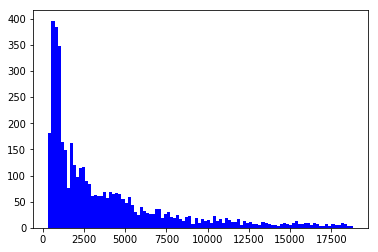

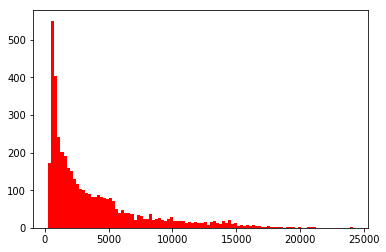

In [20]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

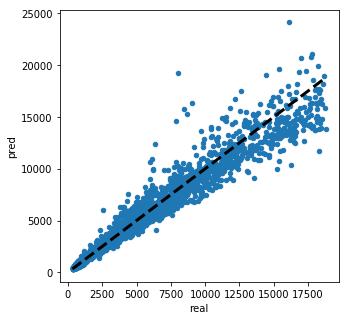

In [21]:
df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)

In [22]:
def oneHotEncoding(features,columnName):
	currentCol = features.columns.get_loc(columnName)
	uniqueFeatures = features[columnName].unique()
	print(uniqueFeatures)
	for f in range(len(uniqueFeatures)):
		features.insert(loc=currentCol+f,column=columnName+str(f),value=0)
		features[columnName+str(f)][features[columnName]==uniqueFeatures[f]] = 1
		
	features.pop(columnName)

def dummieCoding(features,columnName,orderedFeature):
	c = 0
	for f in range(len(orderedFeature)):
		features[columnName][features[columnName]==orderedFeature[f]] = 2**c
		c = c + 1

In [23]:
def RMSE(theta,X,y):
	y_linha = hypothesis(theta,X)
	error = math.sqrt(((y_linha-y)**2).mean())
	return error

#
#  For linear regression, it is possible to estimate the values
# of all parameters theta by applying the normal equation method,
# which corresponds to the following equation:
#
#  Theta = (Xt.X)^-1.Xt.y
#
#  This procedure is called Normal Equation, which is implemented
# here
#
# params:
#   X -> set of features
#   Y -> set of targets
#
# return:
#   theta -> set of parameters
#
def normalEquation(X,y):
	X = np.insert(X,0,1,axis=1)
	npX = np.copy(X)
	npY = y.transpose()
	npXt = npX.transpose()

	R1 = np.matmul(npXt,npX)

	det = np.linalg.det(R1)

	if (det != 0):
		R1 = np.linalg.inv(R1)
		R2 = np.matmul(npXt,npY)
		theta = np.matmul(R1,R2)
	else:
		theta = []
		print("Error! Matrix (Xt.X) has no inverse.")

	error = RMSE(theta,X,y)
	print("Normal Equation --- RMSE error: ",str(error))

	X = np.delete(X,0,axis=1)

	return theta

In [24]:
theta = np.array([1, 0, 1], dtype=np.double)
theta_temp = np.array([0, 0, 0], dtype=np.double)
y = np.array([5.,10.], dtype=np.double)
X = np.array([[0.,1., 2.],[0.,2., 3.]], dtype=np.double)
print (X)
alpha = .01
max_iter = 50

[[0. 1. 2.]
 [0. 2. 3.]]


In [25]:
def hypothesis(theta, X):
    return np.sum(theta.T * X, axis=1)
    
def MSE_theta(theta, X, y, alpha,j, h0, error):                
        S = np.sum(np.matmul(error, X[:,j]))                
        result = theta[j] - (alpha * (1. / len(y)) * S)        
        return result

for i in range(max_iter):
    h0 = hypothesis(theta, X)
    error = (h0 - y)
    for j in range(X.shape[1]):
        theta_temp[j] = MSE_theta(theta, X, y, alpha, j, h0, error)    
        
    theta = theta_temp.copy()
    print (theta)    

hypothesis(theta, X)

[1.    0.085 1.135]
[1.       0.162475 1.257825]
[1.         0.23310013 1.36956737]
[1.         0.29748993 1.47122149]
[1.         0.35620382 1.5636925 ]
[1.         0.40975102 1.64780433]
[1.         0.45859507 1.72430701]
[1.         0.50315792 1.79388325]
[1.         0.54382364 1.85715452]
[1.         0.58094187 1.91468653]
[1.         0.61483086 1.96699423]
[1.         0.64578032 2.01454637]
[1.         0.67405396 2.05776965]
[1.         0.69989182 2.09705246]
[1.         0.72351243 2.13274838]
[1.         0.74511468 2.16517924]
[1.         0.76487964 2.194638  ]
[1.         0.78297213 2.22139134]
[1.         0.79954218 2.24568202]
[1.         0.81472634 2.267731  ]
[1.         0.82864894 2.28773943]
[1.         0.84142314 2.30589041]
[1.         0.85315195 2.32235061]
[1.         0.86392912 2.33727174]
[1.         0.87384003 2.35079191]
[1.         0.88296235 2.36303684]
[1.         0.89136682 2.37412095]
[1.         0.89911781 2.38414842]
[1.         0.90627393 2.39321406]
[1.   

array([5.91038925, 9.35683622])

In [26]:
import math

import math


def SGD_(alpha, max_iter, X, y):
    
    # Creating theta0 
    X = np.insert(X, values=1, obj=0, axis=1)
    
    shape = X.shape
    nsamples = shape[0]
    print("Number of samples: "+str(nsamples))
    theta0 = np.zeros(nsamples)
    nparams = shape[1]
    print("Number of parameters: "+str(nparams))


    theta = np.random.uniform(size=nparams)
    theta_temp = np.ones(nparams)

    error = 1
    epsilon = 0.001
    it = 0
    i = 0   
    power_t = 0.25
    t=1.0
    
    while ((error > epsilon) and (it < max_iter)):
        h0 = hypothesis(theta, X)
        eta = alpha / pow(t, power_t)
        error = (h0 - y)
        for j in range(nparams):
            theta_temp[j] = MSE_theta(theta, X, y, eta, j, h0, error)                
        it += 1
        i += 1
        y_pred = hypothesis(theta_temp, X)
#         print (y,hyphotesis(theta_temp, X))
        error =  ((y - y_pred) ** 2).mean() / 2 
#         print(theta)
#         print(theta_temp)

        theta = theta_temp.copy()
        
        if (i % 100) == 0 or i == 1:
            print("Epoch: %s Batch: %s Error: %.8f lr: %.8f "%(it, i, error, eta))
        t += 1            
   
    return theta
def predict(theta, X):
    X = np.insert(X, values=1, obj=0, axis=1)
    return hypothesis(theta_h, X)

max_iter = 10000
theta_h = SGD_(alpha, max_iter, X, y)
print (y,predict(theta_h, X))


Number of samples: 2
Number of parameters: 4
Epoch: 1 Batch: 1 Error: 6.22728269 lr: 0.01000000 
Epoch: 100 Batch: 100 Error: 0.44624447 lr: 0.00316228 
Epoch: 200 Batch: 200 Error: 0.42580543 lr: 0.00265915 
Epoch: 300 Batch: 300 Error: 0.40989314 lr: 0.00240281 
Epoch: 400 Batch: 400 Error: 0.39580625 lr: 0.00223607 
Epoch: 500 Batch: 500 Error: 0.38302273 lr: 0.00211474 
Epoch: 600 Batch: 600 Error: 0.37124991 lr: 0.00202052 
Epoch: 700 Batch: 700 Error: 0.36029972 lr: 0.00194413 
Epoch: 800 Batch: 800 Error: 0.35004116 lr: 0.00188030 
Epoch: 900 Batch: 900 Error: 0.34037775 lr: 0.00182574 
Epoch: 1000 Batch: 1000 Error: 0.33123552 lr: 0.00177828 
Epoch: 1100 Batch: 1100 Error: 0.32255590 lr: 0.00173641 
Epoch: 1200 Batch: 1200 Error: 0.31429141 lr: 0.00169904 
Epoch: 1300 Batch: 1300 Error: 0.30640276 lr: 0.00166538 
Epoch: 1400 Batch: 1400 Error: 0.29885689 lr: 0.00163481 
Epoch: 1500 Batch: 1500 Error: 0.29162561 lr: 0.00160686 
Epoch: 1600 Batch: 1600 Error: 0.28468460 lr: 0.001

In [27]:
max_iter = 10000
theta_h = SGD_(1., max_iter=max_iter, X=X_train, y=np.log(y_train.values))


Number of samples: 38822
Number of parameters: 12
Epoch: 1 Batch: 1 Error: 3.13180225 lr: 1.00000000 
Epoch: 100 Batch: 100 Error: 0.01897292 lr: 0.31622777 
Epoch: 200 Batch: 200 Error: 0.01270714 lr: 0.26591479 
Epoch: 300 Batch: 300 Error: 0.01111535 lr: 0.24028114 
Epoch: 400 Batch: 400 Error: 0.01062385 lr: 0.22360680 
Epoch: 500 Batch: 500 Error: 0.01045276 lr: 0.21147425 
Epoch: 600 Batch: 600 Error: 0.01038733 lr: 0.20205155 
Epoch: 700 Batch: 700 Error: 0.01035995 lr: 0.19441308 
Epoch: 800 Batch: 800 Error: 0.01034722 lr: 0.18803015 
Epoch: 900 Batch: 900 Error: 0.01034048 lr: 0.18257419 
Epoch: 1000 Batch: 1000 Error: 0.01033631 lr: 0.17782794 
Epoch: 1100 Batch: 1100 Error: 0.01033331 lr: 0.17364082 
Epoch: 1200 Batch: 1200 Error: 0.01033086 lr: 0.16990442 
Epoch: 1300 Batch: 1300 Error: 0.01032870 lr: 0.16653831 
Epoch: 1400 Batch: 1400 Error: 0.01032671 lr: 0.16348127 
Epoch: 1500 Batch: 1500 Error: 0.01032481 lr: 0.16068568 
Epoch: 1600 Batch: 1600 Error: 0.01032298 lr: 

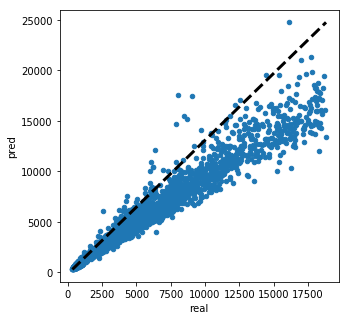

In [28]:
y_pred = np.exp(predict(theta_h, X_val))

df = pd.DataFrame({'real': y_val, 'pred': y_pred})
ax = df.sort_values('real').plot.scatter('real', 'pred', figsize=(5, 5))
_ = ax.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], 'k--', lw=3)



In [29]:
np.mean((np.log(y_pred) - np.log(y_val.values))**2)

0.01962632362822276

In [30]:
np.mean((y_pred - y_val.values)**2)

704081.2163669897

MSE: 704081.216
MAE: 437.794
R2: 0.956


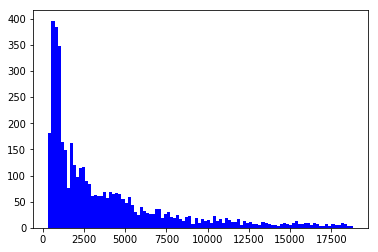

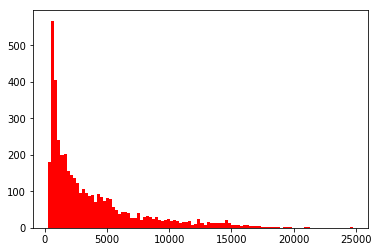

In [31]:
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

Normal Equation --- RMSE error:  0.14107535044765163
MSE: 723753.435
MAE: 437.043
R2: 0.955


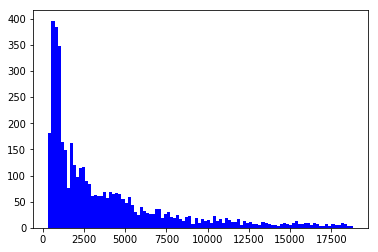

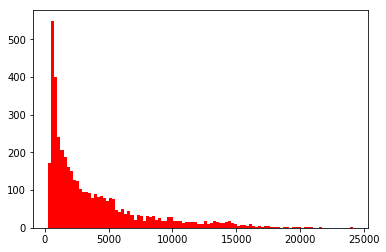

In [32]:
theta_h = normalEquation(X_train, y=np.log(y_train.values))
y_pred = np.exp(predict(theta_h, X_val))
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()

Normal Equation --- RMSE error:  1222.239413134609
MSE: 1425772.421
MAE: 789.754
R2: 0.911


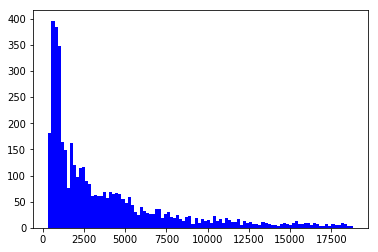

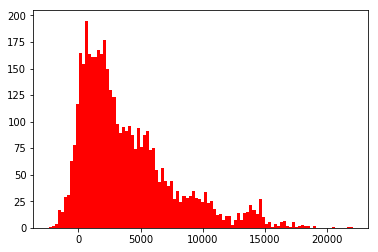

In [33]:
theta_h = normalEquation(X_train, y=y_train.values)
y_pred = predict(theta_h, X_val)
print("MSE: %.3f" % metrics.mean_squared_error(y_val, y_pred))
print("MAE: %.3f" % metrics.mean_absolute_error(y_val, y_pred))
print('R2: %.3f' % metrics.r2_score(y_val, y_pred))

plt.hist(y_val, bins=100, color='blue', linewidth=3)
plt.show()
plt.hist(y_pred, bins=100, color='red', linewidth=3)
plt.show()